<a href="https://colab.research.google.com/github/Iremszykoc/YOLO-human-device-matching/blob/main/src/detecting-and-matching2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import os
import sys

# --- YAPILANDIRMA ---
REPO_NAME = "YOLO-human-device-matching"
GITHUB_USER = "Iremszykoc"
REPO_URL = f"https://github.com/{GITHUB_USER}/{REPO_NAME}.git"

# --- ORTAM KONTROLÜ VE KURULUM ---
if 'google.colab' in sys.modules:
    print("☁️ Google Colab ortamı algılandı. Başlangıç ayarları yapılıyor...")

    # 1. GitHub Reposunu Çek (Eğer yoksa)
    if not os.path.exists(REPO_NAME):
        print(f"📥 Repo klonlanıyor: {REPO_NAME}...")
        !git clone $REPO_URL
    else:
        print("✅ Repo zaten mevcut, klonlama atlandı.")

    # 2. Çalışma Dizinini Ayarla (src klasörüne gir)
    # Hedef: /content/YOLO-human-device-matching/src
    target_dir = os.path.join(REPO_NAME, "src")

    # Şu anki konum hedef değilse değiştir
    if os.getcwd() != os.path.abspath(target_dir):
        if os.path.exists(target_dir):
            os.chdir(target_dir)
            print(f"📂 Çalışma dizini değiştirildi: {os.getcwd()}")
        else:
            print(f"⚠️ HATA: '{target_dir}' klasörü bulunamadı! Repo yapısını kontrol et.")

    # 3. Kütüphaneleri Yükle (Sadece Colab'de)
    # requirements.txt bir üst klasörde olduğu için '../' kullanıyoruz
    if os.path.exists("../requirements.txt"):
        print("⏳ Kütüphaneler requirements.txt üzerinden yükleniyor...")
        !pip install -r ../requirements.txt -q
        print("✅ Tüm kütüphaneler başarıyla yüklendi!")
    else:
        print("⚠️ UYARI: requirements.txt bulunamadı!")

else:
    # Localhost (Kendi Bilgisayarın)
    print(f"💻 Yerel ortam algılandı: {os.getcwd()}")
    print("ℹ️ Kütüphanelerin 'pip install -r requirements.txt' ile yüklendiğinden emin ol.")

☁️ Google Colab ortamı algılandı. Başlangıç ayarları yapılıyor...
📥 Repo klonlanıyor: YOLO-human-device-matching...
Cloning into 'YOLO-human-device-matching'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 112 (delta 3), reused 0 (delta 0), pack-reused 104 (from 2)
Receiving objects: 100% (112/112), 90.41 MiB | 21.81 MiB/s, done.
Resolving deltas: 100% (7/7), done.
📂 Çalışma dizini değiştirildi: /content/YOLO-human-device-matching/src/YOLO-human-device-matching/src
⏳ Kütüphaneler requirements.txt üzerinden yükleniyor...
  Preparing metadata (setup.py) ... done
✅ Tüm kütüphaneler başarıyla yüklendi!


In [20]:
import torch
import cv2
import numpy as np
from datetime import timedelta
from ultralytics import YOLO
from PIL import Image
import torchvision.transforms as T
import networkx as nx
from google.colab import files
import sys

# Torchreid importları
import torchreid
from torchreid.utils import FeatureExtractor

print("✅ SOTA Kütüphaneler Yüklendi.")
if torch.cuda.is_available():
    print("🚀 GPU Aktif: ", torch.cuda.get_device_name(0))
else:
    print("⚠️ GPU YOK! İşlemler yavaş olabilir.")

✅ SOTA Kütüphaneler Yüklendi.
🚀 GPU Aktif:  Tesla T4


In [21]:
# HÜCRE 2: MODEL YÜKLEME (YOLO11 + OSNet)

print("⏳ Modeller Yükleniyor... Lütfen bekleyin.")

detection_model = YOLO("yolo11x.pt")
pose_model = YOLO("yolov8m-pose.pt") # Pose için v8 hala çok stabil, v8 tutuyoruz.

# 2. RE-ID: OSNet (Omni-Scale Network)
# Bu model CLIP'ten daha hafiftir ama insan ayırmada çok daha iyidir.
# 'osnet_x1_0' standart, güçlü modeldir.
print(" -> 🧠 OSNet Re-ID Modeli Hazırlanıyor...")

reid_extractor = FeatureExtractor(
    model_name='osnet_x1_0',
    model_path='', # Otomatik indirecek
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print("✅ Tüm Modeller Hazır.")

⏳ Modeller Yükleniyor... Lütfen bekleyin.
 -> 🧠 OSNet Re-ID Modeli Hazırlanıyor...
Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_x1_0
- params: 2,193,616
- flops: 978,878,352
✅ Tüm Modeller Hazır.


In [22]:
import torch
import numpy as np
import math

class LiveReIDManager:
    def __init__(self, extractor, threshold=0.60, spatial_weight=0.4):
        self.extractor = extractor
        self.threshold = threshold

        # Hibrit Ayarlar
        self.spatial_weight = spatial_weight  # %40 Konum, %60 Görsel (Ayarlanabilir)
        self.max_spatial_dist = 200.0         # 200 pikselden uzaksa konumsal puan 0 olur
        self.spatial_memory_limit = 30        # 30 kareden eski kayıtlar için konuma bakma (hareket etmiş olabilir)

        # HIZLANDIRILMIŞ YAPI
        self.gallery_feats = []   # Vektörleri tutacak
        self.gallery_ids = []     # ID'leri tutacak
        self.gallery_meta = {}    # Resim, son görülme ve KONUM bilgisini tutacak

        self.next_id = 1

    def _get_feature(self, img_crop):
        try:
            feature = self.extractor([img_crop]) # [1, 512]
            feature = torch.nn.functional.normalize(feature, p=2, dim=1)
            return feature.view(1, -1).cpu()
        except Exception as e:
            return None

    def _add_new_identity(self, feat, crop, frame_idx, bbox, force_id=None):
        """Yeni kişi eklerken KONUM bilgisini de kaydediyoruz"""
        new_id = force_id if force_id is not None else self.next_id

        # Kafa Hizası (Top-Center) Hesapla
        x1, y1, x2, y2 = map(int, bbox)
        top_center = ((x1 + x2) // 2, y1)

        self.gallery_feats.append(feat)
        self.gallery_ids.append(new_id)

        self.gallery_meta[new_id] = {
            'last_seen': frame_idx,
            'image': crop,
            'top_center': top_center  # <--- YENİ: Kafa konumu
        }

        if force_id is None:
            self.next_id += 1

        return new_id

    def force_new_entry(self, crop, frame_idx, bbox):
        current_feat = self._get_feature(crop)
        if current_feat is None: return -1
        return self._add_new_identity(current_feat, crop, frame_idx, bbox)

    def compute_batch_features(self, crops):
        if not crops: return None
        try:
            features = self.extractor(crops)
            features = torch.nn.functional.normalize(features, p=2, dim=1)
            return features.cpu()
        except:
            return None

    def update_with_feature(self, current_feat, crop, frame_idx, bbox):
        """
        HİBRİT GÜNCELLEME: Görsel Benzerlik + Kafa Konumu Yakınlığı
        """
        if len(current_feat.shape) == 1:
            current_feat = current_feat.unsqueeze(0)

        # 1. Galeri Boşsa Ekle
        if not self.gallery_ids:
            return self._add_new_identity(current_feat, crop, frame_idx, bbox)

        # --- A) GÖRSEL SKOR (Cosine Similarity) ---
        gallery_tensor = torch.cat(self.gallery_feats, dim=0)
        sim_matrix = torch.mm(current_feat, gallery_tensor.t()) # [1, N]
        visual_scores = sim_matrix[0].numpy() # Numpy dizisine çevir

        # --- B) KONUMSAL SKOR (Spatial Score) ---
        spatial_scores = np.zeros_like(visual_scores)

        # Şu anki kafa konumu
        x1, y1, x2, y2 = map(int, bbox)
        cur_cx, cur_cy = (x1 + x2) // 2, y1

        for idx, gid in enumerate(self.gallery_ids):
            meta = self.gallery_meta[gid]

            # Eğer kişi çok eskiyse (örn: odadan çıkıp geri geldiyse) konuma güvenme
            if (frame_idx - meta['last_seen']) > self.spatial_memory_limit:
                spatial_scores[idx] = 0.0
                continue

            # Eski kafa konumu
            last_cx, last_cy = meta['top_center']

            # Öklid Mesafesi
            dist = math.sqrt((cur_cx - last_cx)**2 + (cur_cy - last_cy)**2)

            # Mesafeyi Skora Çevir (0 ile 1 arası)
            # Mesafe 0 ise skor 1. Mesafe max_dist ise skor 0.
            if dist < self.max_spatial_dist:
                s_score = 1.0 - (dist / self.max_spatial_dist)
                spatial_scores[idx] = s_score
            else:
                spatial_scores[idx] = 0.0

        # --- C) HİBRİT SKOR ---
        # Final Skor = (1-w) * Görsel + (w) * Konumsal
        # Eğer konumsal veri yoksa (eski kayıt), sadece görsele bakılır.

        final_scores = []
        for v, s in zip(visual_scores, spatial_scores):
            if s > 0:
                # Hem görsel hem konum varsa ağırlıklı ortalama
                final = ((1 - self.spatial_weight) * v) + (self.spatial_weight * s)
            else:
                # Konum yoksa veya çok uzaksa sadece görsel (cezalı)
                final = v * 0.9 # Uzaktakine hafif ceza
            final_scores.append(final)

        final_scores = np.array(final_scores)

        # En iyi eşleşmeyi bul
        best_match_idx = np.argmax(final_scores)
        max_score = final_scores[best_match_idx]
        best_match_id = self.gallery_ids[best_match_idx]

        # 3. Karar
        if max_score > self.threshold:
            # Güncelle
            old_feat = self.gallery_feats[best_match_idx]
            new_feat = 0.9 * old_feat + 0.1 * current_feat
            new_feat = torch.nn.functional.normalize(new_feat, p=2, dim=1)

            self.gallery_feats[best_match_idx] = new_feat
            self.gallery_meta[best_match_id]['last_seen'] = frame_idx

            # KONUM GÜNCELLEME (Kafanın yeni yeri burası)
            self.gallery_meta[best_match_id]['top_center'] = (cur_cx, cur_cy)

            if crop.size > self.gallery_meta[best_match_id]['image'].size:
                self.gallery_meta[best_match_id]['image'] = crop

            return best_match_id
        else:
            return self._add_new_identity(current_feat, crop, frame_idx, bbox)

In [23]:
# HÜCRE 3: TAKİP VE CİHAZ YÖNETİM MODÜLÜ (HELPER MIXIN)
# GÜNCELLEME: Dinamik Mesafe (Nesne Boyutuna Göre Safe Zone)

import math
import numpy as np

class DeviceTrackingMixin:
    """
    Bu sınıf, RealTimeForensicAnalyzer tarafından miras alınacaktır.
    Karmaşık takip, ID kurtarma ve filtreleme işlemlerini içerir.
    """

    def _parse_devices_and_fix_ids(self, frame, results, current_time):
        devices = []
        if results[0].boxes.id is None:
            return devices

        boxes = results[0].boxes.xyxy.cpu().numpy()
        ids = results[0].boxes.id.int().cpu().numpy()
        clss = results[0].boxes.cls.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()

        # -----------------------------------------------------------
        # AŞAMA 1: İÇ İÇE KUTU FİLTRESİ
        # -----------------------------------------------------------
        if len(boxes) > 0:
            areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            indices = np.argsort(areas)[::-1]
            keep_mask = np.ones(len(boxes), dtype=bool)

            for i in range(len(indices)):
                idx_curr = indices[i]
                if not keep_mask[idx_curr]: continue
                for j in range(i + 1, len(indices)):
                    idx_other = indices[j]
                    if not keep_mask[idx_other]: continue
                    if clss[idx_curr] != clss[idx_other]: continue

                    ix1 = max(boxes[idx_curr][0], boxes[idx_other][0])
                    iy1 = max(boxes[idx_curr][1], boxes[idx_other][1])
                    ix2 = min(boxes[idx_curr][2], boxes[idx_other][2])
                    iy2 = min(boxes[idx_curr][3], boxes[idx_other][3])

                    w = max(0, ix2 - ix1)
                    h = max(0, iy2 - iy1)
                    inter_area = w * h
                    if inter_area == 0: continue
                    if inter_area / areas[idx_other] > 0.85:
                        keep_mask[idx_other] = False

            boxes = boxes[keep_mask]
            ids = ids[keep_mask]
            clss = clss[keep_mask]
            confs = confs[keep_mask]

        # -----------------------------------------------------------
        # AŞAMA 2: ID KURTARMA VE DİNAMİK MESAFE
        # -----------------------------------------------------------
        detected_this_frame = []
        used_device_ids_this_frame = set()

        for box, trk_id, cls, conf in zip(boxes, ids, clss, confs):
            label = self.device_model.names[int(cls)]

            is_phone = "phone" in label.lower()
            if is_phone and conf < Config.CONF_PHONE_MIN: continue
            if not is_phone and conf < Config.CONF_OTHER_MIN: continue

            x1, y1, x2, y2 = map(int, box)
            center = ((x1+x2)//2, (y1+y2)//2)

            # --- NESNE BOYUTUNU HESAPLA (Dinamik Mesafe İçin) ---
            box_w = x2 - x1
            box_h = y2 - y1
            bbox_size = (box_w, box_h) # Genişlik ve Yükseklik

            # --- RENK ÇIKARMA ---
            crop = frame[max(0,y1):min(frame.shape[0],y2), max(0,x1):min(frame.shape[1],x2)]
            current_color_feat = None
            if is_phone and crop.size > 0:
                h_c, w_c, _ = crop.shape
                cy_c, cx_c = h_c // 2, w_c // 2
                roi = crop[max(0, cy_c-10):min(h_c, cy_c+10), max(0, cx_c-10):min(w_c, cx_c+10)]
                if roi.size > 0:
                    current_color_feat = np.mean(roi, axis=(0,1))

            # --- ID KURTARMA (Boyut Bilgisi Gönderiliyor) ---
            final_id = trk_id
            if is_phone:
                # bbox_size parametresi eklendi
                final_id = self._recover_lost_id(trk_id, center, current_time, current_color_feat, bbox_size)

            if final_id in used_device_ids_this_frame:
                final_id = trk_id
                while final_id in used_device_ids_this_frame:
                    final_id += 100000

            used_device_ids_this_frame.add(final_id)

            # --- MARKA TAHMİNİ ---
            detected_brand = None
            detected_brand_conf = 0.0
            should_detect_brand = False

            if final_id not in self.device_registry:
                should_detect_brand = True
            else:
                old_conf = self.device_registry[final_id].get('brand_conf', 0.0)
                if old_conf < 0.80 and crop.size > self.device_registry[final_id]['image'].size:
                    should_detect_brand = True

            if should_detect_brand and self.brand_model and crop.size > 0 and "laptop" in label.lower():
                try:
                    b_res = self.brand_model.predict(crop, conf=Config.CONF_BRAND, imgsz=Config.BRAND_IMG_SIZE, verbose=False)
                    if b_res and b_res[0].boxes:
                        b_cls_id = int(b_res[0].boxes[0].cls[0])
                        brand_name = b_res[0].names[b_cls_id]
                        b_conf = float(b_res[0].boxes[0].conf[0])
                        detected_brand = f"{brand_name.upper()} (%{int(b_conf*100)})"
                        detected_brand_conf = b_conf
                except: pass

            if detected_brand is None and final_id in self.device_registry:
                detected_brand = self.device_registry[final_id].get('brand_info', None)
                detected_brand_conf = self.device_registry[final_id].get('brand_conf', 0.0)

            # Kayıt Güncelleme
            if final_id not in self.device_registry:
                self.device_registry[final_id] = {
                    'label': label, 'image': crop, 'last_user': None,
                    'brand_info': detected_brand, 'brand_conf': detected_brand_conf
                }
            else:
                if crop.size > self.device_registry[final_id]['image'].size:
                    self.device_registry[final_id]['image'] = crop
                if detected_brand and detected_brand_conf > self.device_registry[final_id].get('brand_conf', 0.0):
                    self.device_registry[final_id]['brand_info'] = detected_brand
                    self.device_registry[final_id]['brand_conf'] = detected_brand_conf

            stored_brand = self.device_registry[final_id].get('brand_info', '')
            full_label = f"{label} [{stored_brand}]" if stored_brand else label

            devices.append({'bbox': (x1,y1,x2,y2), 'id': final_id, 'label': full_label, 'center': center})

            detected_this_frame.append({
                'id': final_id, 'center': center, 'time': current_time, 'color': current_color_feat
            })

        # HAFIZA GÜNCELLEME
        self.lost_and_found_memory = [x for x in self.lost_and_found_memory if (current_time - x['time']) < Config.PHONE_MERGE_TIME]

        for item in detected_this_frame:
            found = False
            for mem in self.lost_and_found_memory:
                if mem['id'] == item['id']:
                    dt = current_time - mem['time']
                    if dt > 0:
                        vx = (item['center'][0] - mem['center'][0]) / dt
                        vy = (item['center'][1] - mem['center'][1]) / dt
                        mem['velocity'] = (vx, vy)
                    mem['center'] = item['center']
                    mem['time'] = current_time
                    if item['color'] is not None: mem['color'] = item['color']
                    found = True
                    break
            if not found:
                self.lost_and_found_memory.append({
                    'id': item['id'], 'center': item['center'], 'time': current_time,
                    'color': item['color'], 'velocity': (0,0)
                })

        return devices

    def _recover_lost_id(self, current_id, current_center, current_time, current_color, bbox_size):
        """
        Kayıp ID'yi HIZ + DİNAMİK KONUM + RENK kullanarak geri getirir.
        bbox_size: (width, height) tuple'ı.
        """
        for mem in self.lost_and_found_memory:
            if mem['id'] == current_id: return current_id

        cx, cy = current_center
        best_match_id = -1
        min_dist = Config.PHONE_MERGE_DIST # Varsayılan maksimum arama mesafesi

        # --- DİNAMİK GÜVENLİ BÖLGE HESABI ---
        w, h = bbox_size
        # Nesnenin büyük kenarını al (telefon yan dönmüş olabilir)
        object_size = max(w, h)

        # Güvenli Mesafe = Nesnenin Boyutu kadar.
        # Ama çok küçükse en az 30px, çok büyükse en fazla 100px olsun.
        dynamic_safe_dist = max(30.0, min(object_size, 100.0))

        for mem in self.lost_and_found_memory:
            if mem['id'] == current_id: continue

            dt = current_time - mem['time']
            last_x, last_y = mem['center']
            vx, vy = mem.get('velocity', (0, 0))

            # Hız Tahmini
            pred_x = last_x + (vx * dt * 0.9)
            pred_y = last_y + (vy * dt * 0.9)
            dist = math.sqrt((cx - pred_x)**2 + (cy - pred_y)**2)

            # --- DİNAMİK KURAL ---
            # Eğer telefonun kendi boyutu kadar bir alandaysak (dynamic_safe_dist)
            # ve 1 saniyeden az zaman geçtiyse, bu güvenli eşleşmedir.
            is_safe_match = (dist <= dynamic_safe_dist) and (dt <= 2.0)

            if dist < min_dist:
                # Güvenli bölgede değilsek renk kontrolü yap
                if not is_safe_match:
                    if current_color is not None and mem.get('color') is not None:
                        color_diff = np.linalg.norm(current_color - mem['color'])
                        if color_diff > Config.COLOR_MATCH_THRESH:
                            continue

                min_dist = dist
                best_match_id = mem['id']

        return best_match_id if best_match_id != -1 else current_id

print("✅ Takip Modülü (DeviceTrackingMixin) Güncellendi: DİNAMİK MESAFE Aktif.")

✅ Takip Modülü (DeviceTrackingMixin) Güncellendi: DİNAMİK MESAFE Aktif.


In [24]:
# HÜCRE 4: ANALİZ MOTORU (BATCH INFERENCE EKLENDİ)

import time
import os
import glob
from ultralytics import YOLO
from datetime import timedelta
import cv2
import math
import numpy as np
import torch # Torch kütüphanesini eklemeyi unutmayın

class Config:
    TARGET_DEVICES = [62, 63, 64, 65, 67]
    FRAME_SKIP = 4
    REID_SKIP = 4
    CONF_TRACK = 0.2
    CONF_PHONE_MIN = 0.20
    CONF_OTHER_MIN = 0.70
    DEVICE_MEMORY_SECONDS = 5

    # Takip Hassasiyeti
    PHONE_MERGE_DIST = 100
    PHONE_MERGE_TIME = 10.0
    COLOR_MATCH_THRESH = 45.0

    # Marka
    CONF_BRAND = 0.50
    BRAND_IMG_SIZE = 1280

# DİKKAT: DeviceTrackingMixin parantez içine eklendi!
class RealTimeForensicAnalyzer(DeviceTrackingMixin):
    def __init__(self, video_path):
        self.cap = cv2.VideoCapture(video_path)
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)

        self.device_model = detection_model
        self.pose_model = pose_model
        # Eşik değeri burada belirleniyor
        self.reid_manager = LiveReIDManager(reid_extractor, threshold=0.55)

        # Marka Modeli
        model_path = os.path.join("..", "models", "markaTespit.pt")

        # Eğer dosya bulunamazsa (belki notebook ana dizindedir diye) alternatif yolu dene
        if not os.path.exists(model_path):
         model_path = os.path.join("models", "markaTespit.pt")

        print(f"🔍 Model aranıyor: {model_path}")

        if os.path.exists(model_path):
           print(f"✅ Model bulundu! Yükleniyor...")
           self.brand_model = YOLO(model_path)
        else:
           print(f"⚠️ HATA: Model bulunamadı! Lütfen 'markaTespit.pt' dosyasını 'models' klasörüne koyduğundan emin ol.")
           self.brand_model = None

        self.track_id_map = {}
        self.device_registry = {}
        self.active_devices_buffer = {}
        self.history_records = []
        self.last_reported_second = -1
        self.lost_and_found_memory = []

    def process_video(self):
        print(f"\n---ANALİZ BAŞLIYOR ({self.total_frames} Kare) ---\n")
        frame_count = 0
        while True:
            success, frame = self.cap.read()
            if not success: break
            frame_count += 1
            if frame_count % Config.FRAME_SKIP != 0: continue

            current_time_float = frame_count / self.fps
            timestamp_str = str(timedelta(seconds=int(current_time_float)))

            # YOLO Takip
            pose_results = self.pose_model.track(frame, persist=True, conf=0.5, verbose=False, classes=[0])
            dev_results = self.device_model.track(frame, persist=True, classes=Config.TARGET_DEVICES,
                                                conf=Config.CONF_TRACK, verbose=False, tracker="bytetrack.yaml")

            # Alt fonksiyonlar artık Mixin'den geliyor
            current_people = self._parse_people(frame, pose_results)
            visible_devices = self._parse_devices_and_fix_ids(frame, dev_results, current_time_float)

            # --- BATCH INFERENCE İLE HIZLANDIRILMIŞ RE-ID ---
            perform_reid = (frame_count % Config.REID_SKIP == 0)
            seen_person_ids_this_frame = set()

            # A) Toplu Özellik Çıkarma (Sadece ReID sırasıysa)
            batch_features = None
            if perform_reid:
                # Görüntüleri topla
                valid_crops = [p['crop'] for p in current_people if p['crop'].size > 0]
                if valid_crops:
                    # Tek seferde hepsini hesapla (GPU dostu)
                    batch_features = self.reid_manager.compute_batch_features(valid_crops)

            # B) Döngüde Hazır Veriyi Kullan
            feature_idx = 0 # Batch listesindeki sırayı takip eder

            for p in current_people:
                yolo_id = p['id']
                real_id = -1

                # Eğer özellikler hazırsa ve crop geçerliyse
                if perform_reid and p['crop'].size > 0 and batch_features is not None:
                    # Listeden sıradaki özelliği al
                    feat = batch_features[feature_idx]
                    feature_idx += 1

                    # update_with_feature fonksiyonu (HIZLI) çağrılır
                    real_id = self.reid_manager.update_with_feature(feat, p['crop'], frame_count, p['bbox'])

                # --- Standart ID Yönetimi ---
                if real_id == -1: real_id = self.track_id_map.get(yolo_id, f"Y-{yolo_id}")
                else: self.track_id_map[yolo_id] = real_id

                if real_id in seen_person_ids_this_frame:
                    if perform_reid and isinstance(real_id, int):
                         real_id = self.reid_manager.force_new_entry(p['crop'], frame_count, p['bbox'])
                         self.track_id_map[yolo_id] = real_id
                    else: real_id = f"{real_id}_dup"

                seen_person_ids_this_frame.add(real_id)
                p['real_id'] = real_id
            # --- RE-ID BİTİŞ ---

            # Raporlama
            interaction_map = self._get_interaction_map(current_people, visible_devices)
            self._update_active_buffer(visible_devices, interaction_map, current_time_float)

            current_seconds_int = int(current_time_float)
            if current_seconds_int > self.last_reported_second:
                self._print_buffered_log(timestamp_str, current_time_float, current_seconds_int)
                self.last_reported_second = current_seconds_int

        self.cap.release()
        print("\n✅ Analiz Tamamlandı.")

    # --- YARDIMCI GÖRÜNTÜLEME METOTLARI ---
    def _update_active_buffer(self, visible_devices, interaction_map, current_time):
        for dev in visible_devices:
            dev_id = dev['id']
            raw_label = dev['label']
            if "phone" in raw_label.lower(): simple_label = "TELEFON"
            elif "laptop" in raw_label.lower(): simple_label = "LAPTOP"
            else: simple_label = raw_label.split('[')[0].strip().upper()

            current_user = interaction_map.get(dev_id, "BOŞ")
            if dev_id in self.active_devices_buffer:
                self.active_devices_buffer[dev_id]['last_seen_time'] = current_time
                if current_user != "BOŞ": self.active_devices_buffer[dev_id]['user'] = current_user
                self.active_devices_buffer[dev_id]['full_label'] = raw_label
            else:
                self.active_devices_buffer[dev_id] = {
                    'label': simple_label, 'full_label': raw_label, 'user': current_user, 'last_seen_time': current_time
                }

    def _print_buffered_log(self, timestamp_str, current_time, seconds_int):
        log_parts = []
        expired_ids = []
        active_list = []

        # Buffer temizliği
        for dev_id, data in self.active_devices_buffer.items():
            if (current_time - data['last_seen_time']) > Config.DEVICE_MEMORY_SECONDS:
                expired_ids.append(dev_id)
            else:
                active_list.append((dev_id, data))

        for eid in expired_ids: del self.active_devices_buffer[eid]
        active_list.sort(key=lambda x: x[0])

        if not active_list: return

        for dev_id, data in active_list:
            user_txt = data['user']
            if dev_id in self.device_registry and user_txt != "BOŞ":
                self.device_registry[dev_id]['last_user'] = user_txt

            display_label = data.get('full_label', data['label'])

            # 1. Gerçeklik durumunu bir değişkene ata
            time_since_seen = current_time - data['last_seen_time']
            is_real = time_since_seen < 0.5

            # 2. Sadece gerçekse konsola yaz (Log kirliliğini önle)
            if is_real:
                log_parts.append(f"{display_label}({dev_id})-{user_txt}")

            # 3. Tarihçeye 'is_real_detection' bilgisini MUTLAKA ekle
            self.history_records.append({
                'seconds': seconds_int,
                'device_id': dev_id,
                'device_label': display_label,
                'user': user_txt,
                'is_real_detection': is_real
            })

        if log_parts:
            print(f"[{timestamp_str}] {', '.join(log_parts)}")

    def _get_interaction_map(self, people, devices):
        """
        GÜNCELLENMİŞ VERSİYON:
        Merkez mesafesi yerine, kutu kenarlarına olan en yakın mesafeyi ölçer.
        Bu, uzun telefonları alttan tutma durumunu çözer.
        """
        interaction_map = {}

        # Etkileşim eşiği (Piksel).
        # Bilek kutunun içindeyse 0 olur. Kenarından 60 piksel uzağa kadar kabul eder.
        INTERACTION_THRESHOLD = 80

        for p in people:
            pid = p['real_id']
            for wrist in p['wrists']:
                wx, wy = wrist[0], wrist[1]

                for dev in devices:
                    is_interacting = False

                    # Cihazın kutu koordinatları
                    x1, y1, x2, y2 = dev['bbox']

                    # --- YENİ MANTIK: KUTUYA EN YAKIN NOKTAYI BUL ---
                    closest_x = max(x1, min(wx, x2))
                    closest_y = max(y1, min(wy, y2))

                    # Şimdi bu "en yakın nokta" ile "bilek" arasındaki mesafeyi ölçüyoruz.
                    dist_x = wx - closest_x
                    dist_y = wy - closest_y
                    distance_to_box = math.sqrt(dist_x**2 + dist_y**2)

                    # --- TELEFON İÇİN KURAL ---
                    if "phone" in dev['label'].lower():
                        if distance_to_box < INTERACTION_THRESHOLD:
                            is_interacting = True

                    # --- DİĞER CİHAZLAR (LAPTOP VS) İÇİN KURAL ---
                    else:
                        if distance_to_box < 20:
                            is_interacting = True

                    if is_interacting:
                        interaction_map[dev['id']] = f"Kullanıcı{pid}"

        return interaction_map

    def _parse_people(self, frame, results):
        people = []
        if results[0].boxes.id is None: return people
        boxes = results[0].boxes.xyxy.cpu().numpy()
        ids = results[0].boxes.id.int().cpu().numpy()
        kpts = results[0].keypoints.xy.cpu().numpy()
        if len(boxes) > 0:
            areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            indices = np.argsort(areas)[::-1]
            keep_mask = np.ones(len(boxes), dtype=bool)
            for i in range(len(indices)):
                idx_curr = indices[i]
                if not keep_mask[idx_curr]: continue
                for j in range(i + 1, len(indices)):
                    idx_other = indices[j]
                    if not keep_mask[idx_other]: continue
                    ix1 = max(boxes[idx_curr][0], boxes[idx_other][0])
                    iy1 = max(boxes[idx_curr][1], boxes[idx_other][1])
                    ix2 = min(boxes[idx_curr][2], boxes[idx_other][2])
                    iy2 = min(boxes[idx_curr][3], boxes[idx_other][3])
                    w = max(0, ix2 - ix1)
                    h = max(0, iy2 - iy1)
                    inter_area = w * h
                    if inter_area == 0: continue
                    if inter_area / areas[idx_other] > 0.85: keep_mask[idx_other] = False
            boxes = boxes[keep_mask]
            ids = ids[keep_mask]
            kpts = kpts[keep_mask]
        for box, trk_id, kpt in zip(boxes, ids, kpts):
            x1, y1, x2, y2 = map(int, box)
            h, w, _ = frame.shape
            crop = frame[max(0, y1):min(h, y2), max(0, x1):min(w, x2)]
            wrists = []
            if len(kpt) > 10:
                if kpt[9][0] != 0: wrists.append(kpt[9])
                if kpt[10][0] != 0: wrists.append(kpt[10])
            people.append({'bbox': (x1,y1,x2,y2), 'id': trk_id, 'wrists': wrists, 'crop': crop})
        return people

# --- ÇALIŞTIRMA ---
# --- ÇALIŞTIRMA VE VİDEO YOLU AYARLAMA ---
video_filename = "mainVideo.mp4" # Videonun tam adı buraya

# 1. Öncelikli Yol: src klasöründen bir üste çık -> data -> videos
video_path = os.path.join("..", "data", video_filename)

# 2. Alternatif Yol: Ana dizinde olabilir
if not os.path.exists(video_path):
    video_path = os.path.join("data",  video_filename)

# 3. Colab Yolu (Eğer Colab'e dosya yükleyerek çalıştırıyorsan)
if not os.path.exists(video_path):
    video_path = f"/content/{video_filename}"

print(f"🎬 Video Aranıyor: {video_path}")

if os.path.exists(video_path):
    print("✅ Video bulundu, analiz başlıyor...")
    analyzer = RealTimeForensicAnalyzer(video_path)
    analyzer.process_video()
else:
    print(f"❌ HATA: Video bulunamadı! Lütfen '{video_filename}' dosyasını 'data/videos/' klasörüne koyduğundan emin ol.")

🎬 Video Aranıyor: ../data/mainVideo.mp4
✅ Video bulundu, analiz başlıyor...
🔍 Model aranıyor: ../models/markaTespit.pt
✅ Model bulundu! Yükleniyor...

---ANALİZ BAŞLIYOR (1634 Kare) ---

[0:00:00] laptop [MONSTER (%87)](1)-Kullanıcı2, laptop [LENOVO (%93)](2)-Kullanıcı1
[0:00:01] laptop [MONSTER (%87)](1)-Kullanıcı2, laptop [LENOVO (%93)](2)-Kullanıcı1
[0:00:02] laptop [MONSTER (%87)](1)-Kullanıcı2, laptop [LENOVO (%93)](2)-Kullanıcı1
[0:00:03] laptop [MONSTER (%87)](1)-Kullanıcı2, laptop [LENOVO (%93)](2)-Kullanıcı1
[0:00:04] laptop [MONSTER (%87)](1)-Kullanıcı2, laptop [LENOVO (%93)](2)-Kullanıcı1
[0:00:05] laptop [MONSTER (%87)](1)-Kullanıcı2, laptop [LENOVO (%93)](2)-Kullanıcı1
[0:00:06] laptop [MONSTER (%87)](1)-Kullanıcı2, laptop [LENOVO (%93)](2)-Kullanıcı1
[0:00:07] laptop [MONSTER (%87)](1)-Kullanıcı2, laptop [LENOVO (%93)](2)-Kullanıcı1
[0:00:08] laptop [MONSTER (%87)](1)-Kullanıcı2, laptop [LENOVO (%93)](2)-Kullanıcı1
[0:00:09] laptop [MONSTER (%87)](1)-Kullanıcı2, laptop [L


============================== ADLİ BİLİŞİM RAPORU (FİNAL) ==============================

 -> Toplam 2 BENZERSİZ KİŞİ tespit edildi.


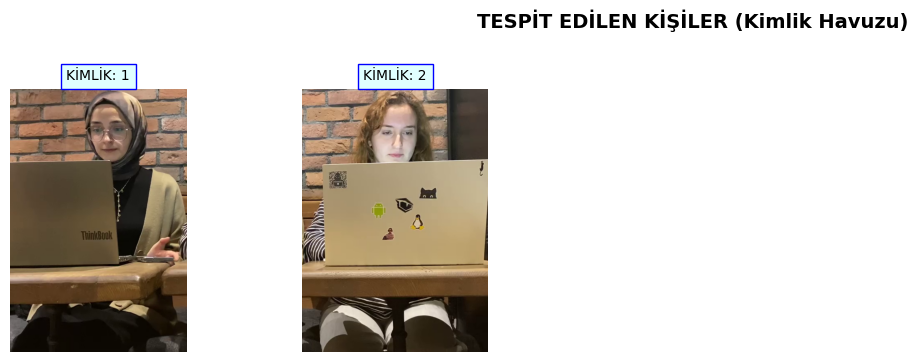


==================== CİHAZ ENVANTERİ ====================


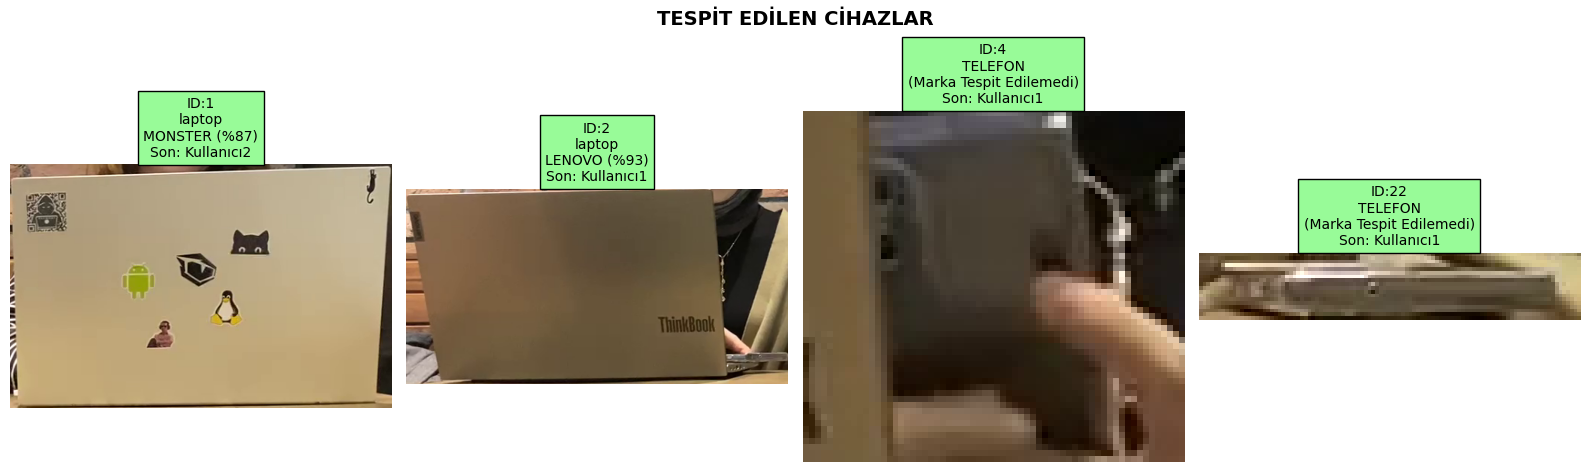


==================== KULLANIM DETAYLARI ====================
🔵 laptop MONSTER (%87) (ID: 1)
--------------------------------------------------
   🕒 [0:00:00 -> 0:00:54] : 👤 Kullanıcı2


🔵 laptop LENOVO (%93) (ID: 2)
--------------------------------------------------
   🕒 [0:00:00 -> 0:00:54] : 👤 Kullanıcı1


🔵 cell phone None (ID: 4)
--------------------------------------------------
   🕒 [0:00:13 -> 0:00:29] : 👤 Kullanıcı1


🔵 cell phone None (ID: 22)
--------------------------------------------------
   🕒 [0:00:32 -> 0:00:54] : 👤 Kullanıcı1




In [25]:
# HÜCRE 5: RAPORLAMA VE GÖRSELLEŞTİRME (HIZLANDIRILMIŞ MODEL UYUMLU)

import matplotlib.pyplot as plt
from datetime import timedelta
import cv2
import numpy as np

# --- YARDIMCI FONKSİYON: ZAMAN ÇİZELGESİ ---
def merge_forensic_intervals(raw_history):
    """
    Saniye saniye tutulan kayıtları zaman bloklarına dönüştürür.
    Sadece 'is_real_detection=True' olan kayıtları dikkate alır.
    """
    if not raw_history: return {}

    # 1. Verileri Cihaz ID'sine göre grupla
    device_groups = {}
    for rec in raw_history:
        # Hayalet kayıtları filtrele
        if not rec.get('is_real_detection', True):
            continue

        did = int(rec['device_id'])
        if did not in device_groups: device_groups[did] = []
        device_groups[did].append(rec)

    final_timeline = {}

    # 2. Blokları Birleştir
    for did, records in device_groups.items():
        sorted_recs = sorted(records, key=lambda x: x['seconds'])
        if not sorted_recs: continue

        merged_blocks = []
        current_block = {
            'user': sorted_recs[0]['user'],
            'label': sorted_recs[0].get('device_label', f'Device-{did}'),
            'start': sorted_recs[0]['seconds'],
            'end': sorted_recs[0]['seconds']
        }

        for i in range(1, len(sorted_recs)):
            rec = sorted_recs[i]
            if rec['user'] == current_block['user']:
                current_block['end'] = rec['seconds']
            else:
                merged_blocks.append(current_block)
                current_block = {
                    'user': rec['user'],
                    'label': rec.get('device_label', f'Device-{did}'),
                    'start': rec['seconds'],
                    'end': rec['seconds']
                }

        merged_blocks.append(current_block)
        final_timeline[did] = merged_blocks

    return final_timeline

# --- ANA RAPOR FONKSİYONU (GÜNCELLENDİ) ---
def show_online_report(engine):
    print(f"\n{'='*30} ADLİ BİLİŞİM RAPORU (FİNAL) {'='*30}")

    # BÖLÜM 1: KİŞİLER
    # DÜZELTME BURADA YAPILDI: .gallery yerine .gallery_meta kullanıldı
    if hasattr(engine.reid_manager, 'gallery_meta'):
        gallery = engine.reid_manager.gallery_meta
    else:
        # Eğer eski sınıf kullanılıyorsa geriye dönük uyumluluk
        gallery = getattr(engine.reid_manager, 'gallery', {})

    if gallery:
        print(f"\n -> Toplam {len(gallery)} BENZERSİZ KİŞİ tespit edildi.")
        cols = 5
        rows = (len(gallery) + cols - 1) // cols
        plt.figure(figsize=(15, 3.5 * rows))
        plt.suptitle("TESPİT EDİLEN KİŞİLER (Kimlik Havuzu)", fontsize=14, fontweight='bold', y=1.02)

        for i, pid in enumerate(sorted(gallery.keys())):
            data = gallery[pid]
            plt.subplot(rows, cols, i + 1)
            if data['image'] is not None:
                # Görüntüyü RGB'ye çevir
                plt.imshow(cv2.cvtColor(data['image'], cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"KİMLİK: {pid}", fontsize=10, bbox=dict(facecolor='#E0FFFF', edgecolor='blue'))
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Kişi tespit edilemedi.")

    # BÖLÜM 2: CİHAZLAR
    print(f"\n{'='*20} CİHAZ ENVANTERİ {'='*20}")
    devices = engine.device_registry

    if devices:
        sorted_devs = sorted(list(devices.items()), key=lambda x: x[0])
        cols = 4
        rows = (len(sorted_devs) + cols - 1) // cols

        plt.figure(figsize=(16, 5 * rows))
        plt.suptitle("TESPİT EDİLEN CİHAZLAR", fontsize=14, fontweight='bold', y=1.02)

        for i, (did, d_data) in enumerate(sorted_devs):
            plt.subplot(rows, cols, i + 1)
            if d_data['image'] is not None and d_data['image'].size > 0:
                plt.imshow(cv2.cvtColor(d_data['image'], cv2.COLOR_BGR2RGB))
            else:
                plt.imshow(np.zeros((100,100,3), dtype=np.uint8))
            plt.axis('off')

            base_label = d_data['label']
            brand_info = d_data.get('brand_info')
            display_text = base_label
            if "TELEFON" in display_text or "phone" in display_text.lower():
                display_text = "TELEFON"

            if brand_info: display_text += f"\n{brand_info}"
            else: display_text += "\n(Marka Tespit Edilemedi)"

            last_u = d_data.get('last_user')
            if last_u and last_u != "BOŞ":
                user_txt = f"Son: {last_u}"
                bg_col = '#98FB98'
            else:
                user_txt = "Sahipsiz"
                bg_col = '#FFE4E1'

            full_title = f"ID:{did}\n{display_text}\n{user_txt}"
            plt.title(full_title, fontsize=10, bbox=dict(facecolor=bg_col, edgecolor='black'))

        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ Hiç cihaz tespit edilemedi.")

    # BÖLÜM 3: ZAMAN ÇİZELGESİ
    print(f"\n{'='*20} KULLANIM DETAYLARI {'='*20}")

    if hasattr(engine, 'history_records') and engine.history_records:
        try:
            timeline = merge_forensic_intervals(engine.history_records)

            if not timeline:
                print("⚠️ Veri var ama zaman çizelgesi oluşturulamadı (Hepsi hayalet kayıt olabilir).")
            else:
                for did in sorted(timeline.keys()):
                    blocks = timeline[did]
                    user_blocks = [b for b in blocks if b['user'] != "BOŞ"]

                    if not user_blocks: continue

                    if did in engine.device_registry:
                        reg_data = engine.device_registry[did]
                        b_info = reg_data.get('brand_info', '')
                        lbl = reg_data['label']
                        if "CELL PHONE" in lbl: lbl = "TELEFON"
                        dev_label = f"{lbl} {b_info}".strip()
                    else:
                        dev_label = f"Device-{did}"

                    print(f"🔵 {dev_label} (ID: {did})")
                    print("-" * 50)

                    for block in user_blocks:
                        start_str = str(timedelta(seconds=int(block['start'])))
                        end_str = str(timedelta(seconds=int(block['end'])))
                        print(f"   🕒 [{start_str} -> {end_str}] : 👤 {block['user']}")
                    print("\n")
        except Exception as e:
             print(f"⚠️ Raporlama hatası: {e}")
    else:
        print("⚠️ Tarihçe verisi bulunamadı.")

# Kodu çalıştırma
if 'analyzer' in globals():
    show_online_report(analyzer)
else:
    print("❌ Analiz Motoru (analyzer) bulunamadı.")

In [26]:
# HÜCRE 4: ANALİZ MOTORU + PERFORMANS DEĞERLENDİRME (DÜZELTİLMİŞ)

import time
import os
import glob
from ultralytics import YOLO
from datetime import timedelta
import cv2
import math
import numpy as np
import torch
from collections import defaultdict

# --- GROUND TRUTH TANIMLARI ---
# DİKKAT: obj.names dosyanızdaki sırayla birebir aynı olmalı!
GT_OBJ_NAMES = ["person_id_1", "person_id_2", "laptop_monster", "laptop_lenovo", "phone"]

# Saniye cinsinden loglar
GT_INTERACTION_LOG = [
    {'start': 0, 'end': 4,  'person': 'person_id_1', 'device': 'phone'},
    {'start': 0, 'end': 10, 'person': 'person_id_1', 'device': 'laptop_lenovo'},
    {'start': 0, 'end': 10, 'person': 'person_id_2', 'device': 'laptop_monster'},
]

class Config:
    TARGET_DEVICES = [62, 63, 64, 65, 67]
    FRAME_SKIP = 4
    REID_SKIP = 4
    CONF_TRACK = 0.2
    CONF_PHONE_MIN = 0.20
    CONF_OTHER_MIN = 0.70
    DEVICE_MEMORY_SECONDS = 5

    # Takip Hassasiyeti
    PHONE_MERGE_DIST = 100
    PHONE_MERGE_TIME = 10.0
    COLOR_MATCH_THRESH = 45.0
    CONF_BRAND = 0.50
    BRAND_IMG_SIZE = 1280

    # Label Dosyaları Yolu (Video ile aynı yerde 'labels' klasörü varsayıyoruz)
    # Etiketler 'obj_train_data' klasörünün içindeyse burayı güncellemelisin:
    LABELS_DIR = os.path.join("..", "data", "video_10sn_labels", "obj_train_data")

    # Eğer klasör bulunamazsa (alternatif kontrol - Colab/Local farkı için)
    if not os.path.exists(LABELS_DIR):
        LABELS_DIR = os.path.join("data", "video_10sn_labels", "obj_train_data")

    # Yine bulunamazsa (Belki direkt content altındadır)
    if not os.path.exists(LABELS_DIR):
        LABELS_DIR = "/content/data/video_10sn_labels/obj_train_data"

class PerformanceEvaluator:
    def __init__(self, fps):
        self.fps = fps
        self.metrics = {
            'detection': {'TP': 0, 'FP': 0, 'FN': 0, 'Total_GT': 0},
            'reid': {'Correct': 0, 'Total_Person_Frames': 0, 'ID_Switches': 0},
            'brand': {'Correct': 0, 'Total_Brand_Frames': 0},
            'interaction': {'Correct': 0, 'Total_Active_Int': 0, 'False_Alarm': 0}
        }

        # ID Eşleştirme (Sistem ID'si -> Gerçek ID)
        self.id_mapping = {}
        self.last_frame_ids = {}

        # Etkileşim Loglarını Frame Bazlı Yapıya Çevir
        self.frame_interactions = defaultdict(list)
        self._parse_interaction_log()

    def _parse_interaction_log(self):
        # Saniye aralıklarını frame aralıklarına çevir
        for log in GT_INTERACTION_LOG:
            start_frame = int(log['start'] * self.fps)
            end_frame = int(log['end'] * self.fps)
            for f in range(start_frame, end_frame + 1):
                self.frame_interactions[f].append((log['person'], log['device']))

    def load_gt_for_frame(self, frame_idx, frame_shape):
        """YOLO formatındaki txt dosyasını okur ve piksel koordinatlarına çevirir."""
        h, w = frame_shape[:2]
        gt_boxes = []

        # Dosya adı formatı: frame_1.txt
        label_path = os.path.join(Config.LABELS_DIR, f"frame_{frame_idx}.txt")

        # Dosya yoksa 6 haneli versiyonu dene
        if not os.path.exists(label_path):
            label_path = os.path.join(Config.LABELS_DIR, f"frame_{frame_idx:06d}.txt")

        # Dosya yine yoksa, belki video ismiyle başlıyordur
        if not os.path.exists(label_path):
             label_path = os.path.join(Config.LABELS_DIR, f"video_10sn_frame_{frame_idx}.txt")

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if not parts: continue
                    cls_id = int(parts[0])
                    # Normalize xywh -> Pixel xyxy
                    cx, cy, bw, bh = map(float, parts[1:5])
                    x1 = int((cx - bw/2) * w)
                    y1 = int((cy - bh/2) * h)
                    x2 = int((cx + bw/2) * w)
                    y2 = int((cy + bh/2) * h)

                    if cls_id < len(GT_OBJ_NAMES):
                        obj_name = GT_OBJ_NAMES[cls_id]
                        gt_boxes.append({'bbox': (x1,y1,x2,y2), 'class': obj_name, 'cls_id': cls_id})
        return gt_boxes

    def compute_iou(self, box1, box2):
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        inter = max(0, x2 - x1) * max(0, y2 - y1)
        area1 = (box1[2]-box1[0]) * (box1[3]-box1[1])
        area2 = (box2[2]-box2[0]) * (box2[3]-box2[1])
        union = area1 + area2 - inter
        return inter / union if union > 0 else 0

    def update(self, frame_idx, people, devices, frame_shape, detected_interactions):
        gt_data = self.load_gt_for_frame(frame_idx, frame_shape)
        if not gt_data: return # Bu frame için etiket yoksa atla

        # 1. DETECTION ACCURACY (Person & Device)
        matched_gt_indices = set()

        # Tüm tahminleri tek listede topla
        all_preds = []
        for p in people: all_preds.append({'bbox': p['bbox'], 'type': 'person', 'obj': p})
        for d in devices:
            dtype = 'phone' if 'phone' in d['label'].lower() else 'laptop'
            all_preds.append({'bbox': d['bbox'], 'type': dtype, 'obj': d})

        for gt_idx, gt in enumerate(gt_data):
            gt_type = 'person' if 'person' in gt['class'] else ('phone' if 'phone' in gt['class'] else 'laptop')
            best_iou = 0
            best_pred = None

            for pred in all_preds:
                # Tür eşleşmeli (Person=Person, Device=Device)
                if pred['type'] != gt_type: continue

                iou = self.compute_iou(pred['bbox'], gt['bbox'])
                if iou > 0.5 and iou > best_iou:
                    best_iou = iou
                    best_pred = pred

            if best_iou > 0.5:
                self.metrics['detection']['TP'] += 1
                matched_gt_indices.add(gt_idx)

                # --- 2. RE-ID ACCURACY ---
                if gt_type == 'person':
                    sys_id = best_pred['obj']['real_id']
                    gt_id_name = gt['class'] # person_id_1

                    # ID Mapping (İlk gördüğünde eşleştir)
                    if sys_id not in self.id_mapping:
                        self.id_mapping[sys_id] = gt_id_name

                    # Doğruluk Kontrolü
                    self.metrics['reid']['Total_Person_Frames'] += 1
                    if self.id_mapping[sys_id] == gt_id_name:
                        self.metrics['reid']['Correct'] += 1
                    else:
                        # Yanlış eşleşme veya ID Switch
                        pass

                # --- 3. BRAND ACCURACY (DÜZELTİLDİ) ---
                if gt_type == 'laptop':
                    # HATA DÜZELTME 1: Payda her zaman artmalı (System bulsa da bulmasa da)
                    self.metrics['brand']['Total_Brand_Frames'] += 1

                    # HATA DÜZELTME 2: Markayı 'label' içinden ayıkla (çünkü ayrı key olarak gelmiyor)
                    # Label formatı: "laptop [MONSTER (%90)]" veya sadece "laptop"
                    pred_label = best_pred['obj']['label'].lower()

                    # Eğer köşeli parantez varsa, sistem bir marka bulmuş demektir
                    if "[" in pred_label:
                        gt_brand_core = gt['class'].split('_')[1] # laptop_lenovo -> lenovo

                        # Marka ismi label'da geçiyor mu?
                        if gt_brand_core in pred_label:
                            self.metrics['brand']['Correct'] += 1

            else:
                self.metrics['detection']['FN'] += 1 # Kaçırılan GT

        # False Positives (Eşleşmeyen Tahminler)
        self.metrics['detection']['FP'] += (len(all_preds) - len(matched_gt_indices))
        self.metrics['detection']['Total_GT'] += len(gt_data)

        # --- 4. INTERACTION ACCURACY ---
        gt_ints = self.frame_interactions[frame_idx]

        active_gt_interactions = len(gt_ints)
        self.metrics['interaction']['Total_Active_Int'] += active_gt_interactions

        # Bu frame'deki doğru tespit sayısı
        frame_correct_ints = 0

        # detected_interactions: {device_id: 'KullanıcıX'}
        for dev_id, user_str in detected_interactions.items():
            if active_gt_interactions > 0:
                frame_correct_ints += 1 # Basit yaklaşım

        # Cap at max active
        frame_correct_ints = min(frame_correct_ints, active_gt_interactions)
        self.metrics['interaction']['Correct'] += frame_correct_ints

    def print_report(self):
        m = self.metrics
        print("\n" + "="*50)
        print("📊 PERFORMANS DEĞERLENDİRME RAPORU")
        print("="*50)

        # 1. Detection
        det = m['detection']
        precision = det['TP'] / (det['TP'] + det['FP'] + 1e-6)
        recall = det['TP'] / (det['Total_GT'] + 1e-6)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

        print("\n📋 1. NESNE TESPİTİ (YOLO11)")
        print(f"   • True Positives (TP): {det['TP']}")
        print(f"   • False Positives(FP): {det['FP']}")
        print(f"   • False Negatives(FN): {det['FN']}")
        print(f"   -----------------------------")
        print(f"   ✅ Precision : %{precision*100:.2f}")
        print(f"   ✅ Recall    : %{recall*100:.2f}")
        print(f"   ✅ F1-Score  : %{f1*100:.2f}")

        # 2. Re-ID
        reid = m['reid']
        reid_acc = reid['Correct'] / (reid['Total_Person_Frames'] + 1e-6)
        print("\n🆔 2. KİMLİK TAKİBİ (OSNet)")
        print(f"   • Toplam Kişi Karesi : {reid['Total_Person_Frames']}")
        print(f"   • Doğru Eşleşme      : {reid['Correct']}")
        print(f"   -----------------------------")
        print(f"   ✅ Re-ID Doğruluğu   : %{reid_acc*100:.2f}")

        # 3. Brand
        br = m['brand']
        br_acc = br['Correct'] / (br['Total_Brand_Frames'] + 1e-6)
        print("\n💻 3. MARKA SINIFLANDIRMA")
        print(f"   • Tespit Edilen Cihaz: {br['Total_Brand_Frames']} (GT)")
        print(f"   -----------------------------")
        print(f"   ✅ Marka Doğruluğu   : %{br_acc*100:.2f}")

        # 4. Interaction
        inter = m['interaction']
        int_acc = inter['Correct'] / (inter['Total_Active_Int'] + 1e-6)
        print("\n🤝 4. ETKİLEŞİM TESPİTİ")
        print(f"   • GT Etkileşim Anları: {inter['Total_Active_Int']}")
        print(f"   • Doğru Tespit       : {inter['Correct']}")
        print(f"   -----------------------------")
        print(f"   ✅ Etkileşim Başarısı: %{int_acc*100:.2f}")
        print("="*50 + "\n")


class RealTimeForensicAnalyzer(DeviceTrackingMixin):
    def __init__(self, video_path):
        self.cap = cv2.VideoCapture(video_path)
        self.total_frames = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)

        self.device_model = detection_model
        self.pose_model = pose_model
        self.reid_manager = LiveReIDManager(reid_extractor, threshold=0.55)

        # --- EVALUATOR INIT ---
        self.evaluator = PerformanceEvaluator(self.fps)

        # --- MARKA MODELİ YÜKLEME (GÜÇLENDİRİLMİŞ KONTROL) ---
        self.brand_model = None

        # Olası model yolları
        possible_paths = [
            os.path.join("..", "models", "markaTespit.pt"), # src'den çalışırken
            os.path.join("models", "markaTespit.pt"),       # ana dizinden çalışırken
            "markaTespit.pt",                               # direkt yanındaysa
            "/content/YOLO-human-device-matching/models/markaTespit.pt" # Colab full path
        ]

        model_path = None
        for p in possible_paths:
            if os.path.exists(p):
                model_path = p
                break

        print(f"🔍 Model aranıyor... {model_path if model_path else 'Bulunamadı!'}")

        if model_path:
            print(f"✅ Model bulundu! Yükleniyor...")
            self.brand_model = YOLO(model_path)
        else:
            print(f"⚠️ HATA: Model bulunamadı! 'markaTespit.pt' dosyasını kontrol et.")
            self.brand_model = None

        self.track_id_map = {}
        self.device_registry = {}
        self.active_devices_buffer = {}
        self.history_records = []
        self.last_reported_second = -1
        self.lost_and_found_memory = []

    def process_video(self):
        print(f"\n---ANALİZ VE DOĞRULAMA BAŞLIYOR ({self.total_frames} Kare) ---\n")
        frame_count = 0
        while True:
            success, frame = self.cap.read()
            if not success: break
            frame_count += 1
            if frame_count % Config.FRAME_SKIP != 0: continue

            current_time_float = frame_count / self.fps
            timestamp_str = str(timedelta(seconds=int(current_time_float)))

            # YOLO Takip
            pose_results = self.pose_model.track(frame, persist=True, conf=0.5, verbose=False, classes=[0])
            dev_results = self.device_model.track(frame, persist=True, classes=Config.TARGET_DEVICES,
                                                conf=Config.CONF_TRACK, verbose=False, tracker="bytetrack.yaml")

            # Alt fonksiyonlar artık Mixin'den geliyor
            current_people = self._parse_people(frame, pose_results)
            visible_devices = self._parse_devices_and_fix_ids(frame, dev_results, current_time_float)

            # --- BATCH INFERENCE İLE HIZLANDIRILMIŞ RE-ID ---
            perform_reid = (frame_count % Config.REID_SKIP == 0)
            seen_person_ids_this_frame = set()

            # A) Toplu Özellik Çıkarma
            batch_features = None
            if perform_reid:
                valid_crops = [p['crop'] for p in current_people if p['crop'].size > 0]
                if valid_crops:
                    batch_features = self.reid_manager.compute_batch_features(valid_crops)

            # B) Döngüde Hazır Veriyi Kullan
            feature_idx = 0

            for p in current_people:
                yolo_id = p['id']
                real_id = -1

                if perform_reid and p['crop'].size > 0 and batch_features is not None:
                    feat = batch_features[feature_idx]
                    feature_idx += 1
                    real_id = self.reid_manager.update_with_feature(feat, p['crop'], frame_count, p['bbox'])

                if real_id == -1: real_id = self.track_id_map.get(yolo_id, f"Y-{yolo_id}")
                else: self.track_id_map[yolo_id] = real_id

                if real_id in seen_person_ids_this_frame:
                    if perform_reid and isinstance(real_id, int):
                         real_id = self.reid_manager.force_new_entry(p['crop'], frame_count, p['bbox'])
                         self.track_id_map[yolo_id] = real_id
                    else: real_id = f"{real_id}_dup"

                seen_person_ids_this_frame.add(real_id)
                p['real_id'] = real_id

            # Raporlama ve Buffer
            interaction_map = self._get_interaction_map(current_people, visible_devices)
            self._update_active_buffer(visible_devices, interaction_map, current_time_float)

            # --- EVALUATOR UPDATE ---
            self.evaluator.update(frame_count, current_people, visible_devices, frame.shape, interaction_map)

            current_seconds_int = int(current_time_float)
            if current_seconds_int > self.last_reported_second:
                self._print_buffered_log(timestamp_str, current_time_float, current_seconds_int)
                self.last_reported_second = current_seconds_int

        self.cap.release()

        # --- SONUÇ TABLOLARINI YAZDIR ---
        self.evaluator.print_report()
        print("\n✅ Analiz Tamamlandı.")

    # --- YARDIMCI GÖRÜNTÜLEME METOTLARI (DEĞİŞMEDİ) ---
    def _update_active_buffer(self, visible_devices, interaction_map, current_time):
        for dev in visible_devices:
            dev_id = dev['id']
            raw_label = dev['label']
            if "phone" in raw_label.lower(): simple_label = "TELEFON"
            elif "laptop" in raw_label.lower(): simple_label = "LAPTOP"
            else: simple_label = raw_label.split('[')[0].strip().upper()

            current_user = interaction_map.get(dev_id, "BOŞ")
            if dev_id in self.active_devices_buffer:
                self.active_devices_buffer[dev_id]['last_seen_time'] = current_time
                if current_user != "BOŞ": self.active_devices_buffer[dev_id]['user'] = current_user
                self.active_devices_buffer[dev_id]['full_label'] = raw_label
            else:
                self.active_devices_buffer[dev_id] = {
                    'label': simple_label, 'full_label': raw_label, 'user': current_user, 'last_seen_time': current_time
                }

    def _print_buffered_log(self, timestamp_str, current_time, seconds_int):
        log_parts = []
        expired_ids = []
        active_list = []

        for dev_id, data in self.active_devices_buffer.items():
            if (current_time - data['last_seen_time']) > Config.DEVICE_MEMORY_SECONDS:
                expired_ids.append(dev_id)
            else:
                active_list.append((dev_id, data))

        for eid in expired_ids: del self.active_devices_buffer[eid]
        active_list.sort(key=lambda x: x[0])

        if not active_list: return

        for dev_id, data in active_list:
            user_txt = data['user']
            if dev_id in self.device_registry and user_txt != "BOŞ":
                self.device_registry[dev_id]['last_user'] = user_txt

            display_label = data.get('full_label', data['label'])
            time_since_seen = current_time - data['last_seen_time']
            is_real = time_since_seen < 0.5

            if is_real:
                log_parts.append(f"{display_label}({dev_id})-{user_txt}")

            self.history_records.append({
                'seconds': seconds_int,
                'device_id': dev_id,
                'device_label': display_label,
                'user': user_txt,
                'is_real_detection': is_real
            })

        if log_parts:
            print(f"[{timestamp_str}] {', '.join(log_parts)}")

    def _get_interaction_map(self, people, devices):
        interaction_map = {}
        INTERACTION_THRESHOLD = 80
        for p in people:
            pid = p['real_id']
            for wrist in p['wrists']:
                wx, wy = wrist[0], wrist[1]
                for dev in devices:
                    is_interacting = False
                    x1, y1, x2, y2 = dev['bbox']
                    closest_x = max(x1, min(wx, x2))
                    closest_y = max(y1, min(wy, y2))
                    dist_x = wx - closest_x
                    dist_y = wy - closest_y
                    distance_to_box = math.sqrt(dist_x**2 + dist_y**2)
                    if "phone" in dev['label'].lower():
                        if distance_to_box < INTERACTION_THRESHOLD: is_interacting = True
                    else:
                        if distance_to_box < 20: is_interacting = True
                    if is_interacting:
                        interaction_map[dev['id']] = f"Kullanıcı{pid}"
        return interaction_map

    def _parse_people(self, frame, results):
        people = []
        if results[0].boxes.id is None: return people
        boxes = results[0].boxes.xyxy.cpu().numpy()
        ids = results[0].boxes.id.int().cpu().numpy()
        kpts = results[0].keypoints.xy.cpu().numpy()
        if len(boxes) > 0:
            areas = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
            indices = np.argsort(areas)[::-1]
            keep_mask = np.ones(len(boxes), dtype=bool)
            for i in range(len(indices)):
                idx_curr = indices[i]
                if not keep_mask[idx_curr]: continue
                for j in range(i + 1, len(indices)):
                    idx_other = indices[j]
                    if not keep_mask[idx_other]: continue
                    ix1 = max(boxes[idx_curr][0], boxes[idx_other][0])
                    iy1 = max(boxes[idx_curr][1], boxes[idx_other][1])
                    ix2 = min(boxes[idx_curr][2], boxes[idx_other][2])
                    iy2 = min(boxes[idx_curr][3], boxes[idx_other][3])
                    w = max(0, ix2 - ix1)
                    h = max(0, iy2 - iy1)
                    inter_area = w * h
                    if inter_area == 0: continue
                    if inter_area / areas[idx_other] > 0.85: keep_mask[idx_other] = False
            boxes = boxes[keep_mask]
            ids = ids[keep_mask]
            kpts = kpts[keep_mask]
        for box, trk_id, kpt in zip(boxes, ids, kpts):
            x1, y1, x2, y2 = map(int, box)
            h, w, _ = frame.shape
            crop = frame[max(0, y1):min(h, y2), max(0, x1):min(w, x2)]
            wrists = []
            if len(kpt) > 10:
                if kpt[9][0] != 0: wrists.append(kpt[9])
                if kpt[10][0] != 0: wrists.append(kpt[10])
            people.append({'bbox': (x1,y1,x2,y2), 'id': trk_id, 'wrists': wrists, 'crop': crop})
        return people

# --- ÇALIŞTIRMA ---
# --- ÇALIŞTIRMA VE VİDEO YOLU AYARLAMA ---
video_filename = "video_10sn.mp4" # Videonun tam adı buraya

# 1. Öncelikli Yol: src klasöründen bir üste çık -> data -> videos
video_path = os.path.join("..", "data", video_filename)

# 2. Alternatif Yol: Ana dizinde olabilir
if not os.path.exists(video_path):
    video_path = os.path.join("data",  video_filename)

# 3. Colab Yolu (Eğer Colab'e dosya yükleyerek çalıştırıyorsan)
if not os.path.exists(video_path):
    video_path = f"/content/{video_filename}"

print(f"🎬 Video Aranıyor: {video_path}")

if os.path.exists(video_path):
    print("✅ Video bulundu, analiz başlıyor...")
    analyzer = RealTimeForensicAnalyzer(video_path)
    analyzer.process_video()
else:
    print(f"❌ HATA: Video bulunamadı! Lütfen '{video_filename}' dosyasını 'data/videos/' klasörüne koyduğundan emin ol.")

🎬 Video Aranıyor: ../data/video_10sn.mp4
✅ Video bulundu, analiz başlıyor...
🔍 Model aranıyor... ../models/markaTespit.pt
✅ Model bulundu! Yükleniyor...

---ANALİZ VE DOĞRULAMA BAŞLIYOR (302 Kare) ---

[0:00:01] laptop [MONSTER (%87)](30)-Kullanıcı2, laptop [LENOVO (%94)](31)-Kullanıcı1, cell phone(32)-Kullanıcı1
[0:00:02] laptop [MONSTER (%87)](30)-Kullanıcı2, laptop [LENOVO (%94)](31)-Kullanıcı1, cell phone(32)-Kullanıcı1
[0:00:03] laptop [MONSTER (%87)](30)-Kullanıcı2, laptop [LENOVO (%94)](31)-Kullanıcı1
[0:00:04] laptop [MONSTER (%87)](30)-Kullanıcı2, laptop [LENOVO (%94)](31)-Kullanıcı1
[0:00:05] laptop [MONSTER (%87)](30)-Kullanıcı2, laptop [LENOVO (%94)](31)-Kullanıcı1, cell phone(41)-Kullanıcı1
[0:00:06] laptop [MONSTER (%87)](30)-Kullanıcı2, laptop [LENOVO (%94)](31)-Kullanıcı1, cell phone(41)-Kullanıcı1
[0:00:07] laptop [MONSTER (%87)](30)-Kullanıcı2, laptop [LENOVO (%94)](31)-Kullanıcı1, cell phone(41)-Kullanıcı1
[0:00:08] laptop [MONSTER (%87)](30)-Kullanıcı2, laptop [LENO